<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Israel Rodríguez
- Nombre de alumno 2: Benjamín Torrealba


### **Link de repositorio de GitHub:** https://github.com/BnjmnNicholas/MDS7202-2023-2

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


In [2]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import  DummyClassifier
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import mean_absolute_error, classification_report 
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import joblib

## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?. 

In [3]:
# vemos las columnas del dataset
print('Columnas del dataset: ', df.columns.to_list())


Columnas del dataset:  ['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Stroke', 'HighBP', 'Diabetes']


In [4]:
def categorical(df):
    """
    Returns categorical columns from the dataframe
    """
    categorical_columns = []
    for col in df.columns:
        if df[col].dtype == 'object':
            categorical_columns.append(col)
    return categorical_columns

In [5]:
categorical(df)

[]

Con esto notamos que todas las columnas del dataset son numericas.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   70692 non-null  float64
 1   Sex                   70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   HeartDiseaseorAttack  70692 non-null  float64
 7   PhysActivity          70692 non-null  float64
 8   Fruits                70692 non-null  float64
 9   Veggies               70692 non-null  float64
 10  HvyAlcoholConsump     70692 non-null  float64
 11  GenHlth               70692 non-null  float64
 12  MentHlth              70692 non-null  float64
 13  PhysHlth              70692 non-null  float64
 14  DiffWalk              70692 non-null  float64
 15  Stroke             

In [7]:
# descripción de las columnas
df.describe()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,8.584055,0.456997,0.525703,0.975259,29.856985,0.475273,0.147810,0.703036,0.611795,0.788774,0.042721,2.837082,3.752037,5.810417,0.252730,0.062171,0.563458,0.500000
std,2.852153,0.498151,0.499342,0.155336,7.113954,0.499392,0.354914,0.456924,0.487345,0.408181,0.202228,1.113565,8.155627,10.062261,0.434581,0.241468,0.495960,0.500004
min,1.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,0.000000,1.000000,1.000000,29.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000
75%,11.000000,1.000000,1.000000,1.000000,33.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000
max,13.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,1.000000,1.000000


Observamos a partir de la descripción de las columnas que la mayoría de valores están entre 0 y 1, sin embargo hay algunas columnas (Age, BMI, GenHlth, PhysHlth) que tienen valores fuera de este intervalo. Para un mejor performance de los modelos debemos realizar un escalado al dataset.

In [8]:
# Split Data

train, test = train_test_split(df, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

X_train = train.drop(columns=['Diabetes'])
y_train = train['Diabetes']

X_val = val.drop(columns=['Diabetes'])
y_val = val['Diabetes']

X_test = test.drop(columns=['Diabetes'])
y_test = test['Diabetes']

In [9]:
columns_preprocessing = X_train.columns.to_list()

In [10]:
# Preprocessing

# Creamos el ColumnTransformer que procesa los datos numericos y categoricos
preprossesor = ColumnTransformer([
    ('numerical', MinMaxScaler(), columns_preprocessing)
])

preprossesor

ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                 ['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI',
                                  'Smoker', 'HeartDiseaseorAttack',
                                  'PhysActivity', 'Fruits', 'Veggies',
                                  'HvyAlcoholConsump', 'GenHlth', 'MentHlth',
                                  'PhysHlth', 'DiffWalk', 'Stroke',
                                  'HighBP'])])

In [11]:
# Pipeline XGBoost

pipeline_xgb = Pipeline([
        ('preprossesor', preprossesor),
        ('classifier', XGBClassifier(random_state=42))
])
pipeline_xgb

Pipeline(steps=[('preprossesor',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  ['Age', 'Sex', 'HighChol',
                                                   'CholCheck', 'BMI', 'Smoker',
                                                   'HeartDiseaseorAttack',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'GenHlth', 'MentHlth',
                                                   'PhysHlth', 'DiffWalk',
                                                   'Stroke', 'HighBP'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbac...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

A modo de comparación realizaremos el mismo procedimiento con un clasificador Dummy.

In [12]:
# Dummy classifier (only for baseline comparison)

pipeline_dummy = Pipeline([
        ('preprossesor', preprossesor),
        ('classifier', DummyClassifier())
])

pipeline_dummy.fit(X = X_train, y=y_train)
val_predictions_dummy = pipeline_dummy.predict(X_val)
# classification_report
print(classification_report(y_val, val_predictions_dummy))

              precision    recall  f1-score   support

         0.0       0.49      1.00      0.66      6239
         1.0       0.00      0.00      0.00      6486

    accuracy                           0.49     12725
   macro avg       0.25      0.50      0.33     12725
weighted avg       0.24      0.49      0.32     12725



e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# XGB train

pipeline_xgb.fit(X = X_train, y=y_train)
val_predictions_xgb = pipeline_xgb.predict(X_val)

# classification_report
print(classification_report(y_val, val_predictions_xgb))

              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      6239
         1.0       0.74      0.78      0.76      6486

    accuracy                           0.75     12725
   macro avg       0.75      0.75      0.75     12725
weighted avg       0.75      0.75      0.75     12725



#### Comentarios:

En primer lugar observamos que el rendimiento de 'XGBClassifier' es superior al del clasificador Dummy por lo tanto podríamos decir que es un clasificador decente, con respecto a uno pseudo-aleatorio.

Ahora bien, con respecto a las métricas obtenidas:

-   Precision: Corresponde a la proporción de clasificaciones positivas que son realmente positivas. Ambas clases poseen un valor cercano al 75%, lo cual indica que 3 de cada 4 predicciones positivas son correctas. Es un valor bueno pero bastante mejorable.

- Recall: Corresponde a la proporción de clasificaciones positivas correctas. Para los pacientes con diabetes se tiene un recall de 78%, esto indica que de los pacientes con diabetes, se estaría detectando 8/10. Para los pacientes sin diabetes, se tiene un recall de 71%, de los pacientes sin diabetes, el modelo detecta 7/10. Es bastante mejorable

- F1-Score: Observamos valores similares, lo cual tiene sentido ya que tenemos un balance entre clases.

- Accuracy: 75%. 3 de cada 4 instancias son correctamente clasificadas. El modelo es bastante mejorable. 


Para mejorar el modelo se podrían realizar ajustes de hiperparámetros o simplemente ocupar algun otro modelo mejor. También sería bueno revisar si es que se tienen datos corruptos que afecten el performance del modelo.

Las métricas empleadas para evaluar el rendimiento del modelo no facilitan directamente la toma de decisiones sobre las características (features) a utilizar. Si bien estas métricas están vinculadas a las predicciones del modelo, no reflejan el impacto específico de una característica en la decisión que toma el modelo.

## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

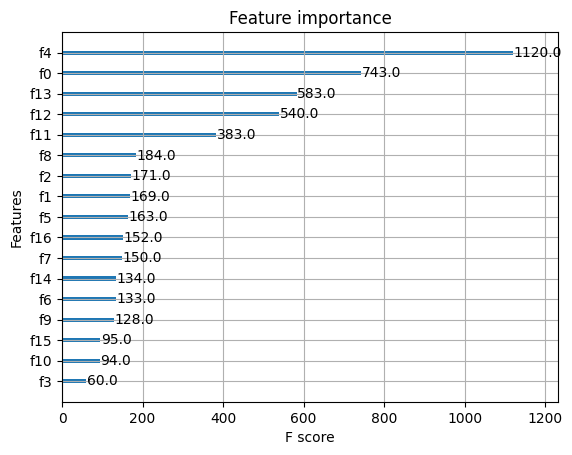

In [14]:
# Calcula la importancia de las features con el modelo entrenado (weight)

plot_importance(pipeline_xgb['classifier'], importance_type='weight')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

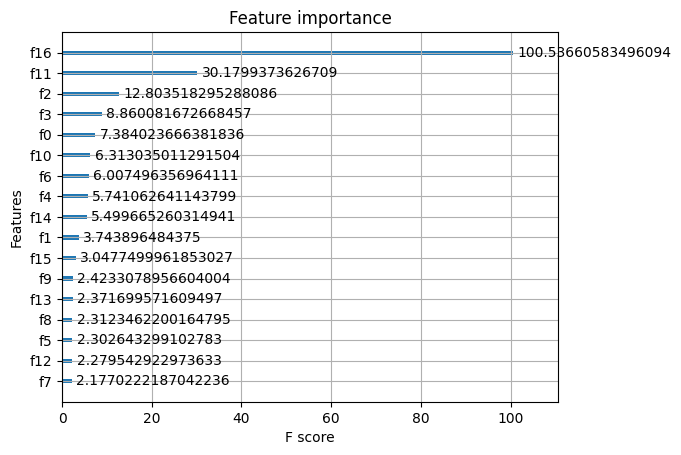

In [15]:
plot_importance(pipeline_xgb['classifier'], importance_type='gain')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

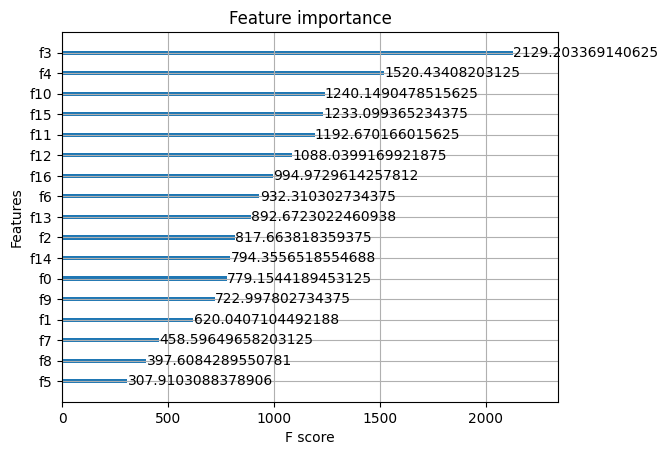

In [16]:
plot_importance(pipeline_xgb['classifier'], importance_type='cover')

In [17]:
columns_preprocessing[15]

'Stroke'

#### Comentarios:


-   Weight: Observamos que el top 5 features son f4, f0, f13, f12 y f11, las cuales corresponden a 'BMI', 'Age', 'PhysHlth', 'MentHlth' y 'GenHlth' respectivamente. Estas features son las que aparecen con más frecuencia en los arboles. 

-   Gain: Observamos que el top 5 features son f16, f11, f2, f3 y f0, las cuales corresponden a 'HighBP', 'GenHlth', 'HighChol', 'CholCheck' y 'Age' respectivamente. Estas son las features que tienen una mayor contribución a la capacidad predictiva del modelo. 

-   Cover: Corresponde a una medida ponderada que refleja la cnatidad de datos influenciados por una determinada caracteristica en un noddo. Observamos que el top 5 features son f3, f4, f10, f15 y f11, las cuales corresponden a 'CholCheck', 'BMI', 'HvyAlcoholConsump', 'Stroke' y 'GenHlth' respectivamente.


Los resultados son en cierta medida compatibles, tenemos features que se repiten en el top 5, sin embargo, se observan posiciones distintas. 


Esta medida puede ser útil. Sin embargo, puede inducir a error en el caso de características con muchos valores posibles, ya que estas características pueden utilizarse con más frecuencia simplemente porque hay más oportunidades de dividirlas. 



## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

In [18]:
result = permutation_importance(pipeline_xgb['classifier'], X_test, y_test, n_repeats=50, random_state=42)

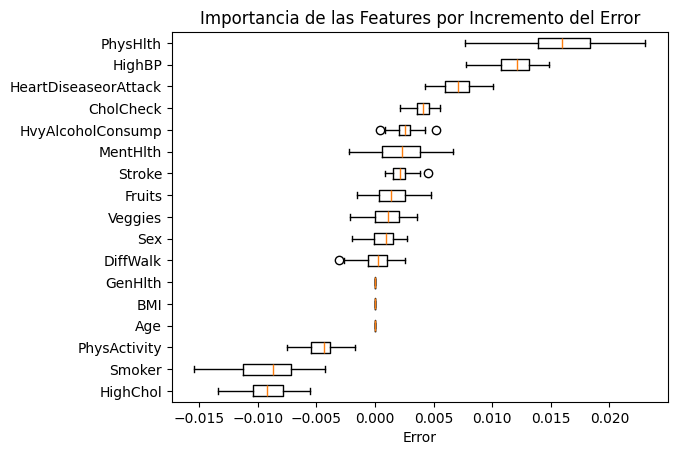

In [19]:
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(columns_preprocessing)[perm_sorted_idx],
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

El método de permutación es una técnica que posibilita la evaluación de la importancia de una característica al intercambiar sus valores de manera aleatoria, manteniendo las demás características inalteradas. Se mide el impacto resultante en el rendimiento del modelo, y si se observa una disminución significativa, se puede inferir que la característica permutada es importante para el modelo.


Las features con mayor importancia para el modelo son las que se encuentran más arriba, en este caso, corresponden a 'PhysHlth', 'HighBP', 'HeartDiseasorAttack', 'CholCheck', 'HvyAlcoholConsump' y 'MentHlth'. 
Se observa que las primera feature posee una gran desviación con respecto a las demás, esto sugiere que el modelo es  muy sensible a una permutación que la relacione. 

Con respecto a las demás, observamos que poseen desviaciones similares y errores tendientes a cero. Un error igual a cero indica que el modelo es indiferente a permutaciones que afecten a dicha feature. Por otro lado, se observan features con errores negativos, esto se puede deber a la aletoriedad asociada al método, en algunos casos la permutaciones puede generar un conjunto de datos que por casualidad tiene caracteristicas que permiten una mejor clasificación. 



Dentro de las ventajas de utilizar este método se tiene:

1. El método de permutación se puede aplicar a una variedad de algoritmos de aprendizaje automático sin tener que hacer ajustes específicos, ya que el método es agnóstico al modelo.

2. Es un método robusto frente a problemas como la multicolinealidad, ya que el análisis se realiza de manera individual.

3. Al permutar una característica, se podría afectar la importancia de las otras, por lo que este método ayuda a revelar interacciones entre características.

Dentro de las desventajas de utilizar este método se tiene:

1. Ya que se tiene que ajustar el modelo varias veces, este método tiene un costo computacional alto que crece junto a la complejidad del modelo y tamaño del dataset.

2. Es un método sensible a la cantidad de permutaciones que se hacen, una cantidad baja de permutaciones puede llevar a malas estimaciones de importancia.

3. La interpretación de la importancia de las caracteristicas puede llegar a depender del conjunto de datos especifico utilizado.

## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [20]:
#!pip install shap

In [21]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [22]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [23]:
# Inserte código para calcular shapley values aquí
explainer = shap.TreeExplainer(pipeline_xgb['classifier'])
shap_values = explainer(X_train)

[17:51:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [24]:
shap_values

.values =
array([[-0.06666017, -0.12586199,  0.17276827, ..., -0.25811443,
        -0.03079482,  0.52931243],
       [ 0.36378103, -0.08366421,  0.18411313, ...,  0.02656455,
        -0.01090183, -0.68073505],
       [ 0.02247164, -0.12496373,  0.10273028, ..., -0.16145085,
        -0.01748495,  0.6149581 ],
       ...,
       [ 0.37485895,  0.12626612,  0.14024621, ...,  0.03019161,
        -0.00889393,  0.49401835],
       [ 0.3401848 , -0.04423827, -0.27404198, ..., -0.14335448,
        -0.02586924,  0.4676353 ],
       [ 0.4965626 , -0.08656764, -0.18539438, ...,  0.05941055,
         0.01102423,  0.469902  ]], dtype=float32)

.base_values =
array([-0.01295933, -0.01295933, -0.01295933, ..., -0.01295933,
       -0.01295933, -0.01295933], dtype=float32)

.data =
array([[ 6.,  0.,  1., ...,  0.,  0.,  1.],
       [10.,  0.,  1., ...,  0.,  0.,  0.],
       [ 8.,  0.,  1., ...,  0.,  0.,  1.],
       ...,
       [ 9.,  1.,  1., ...,  0.,  0.,  1.],
       [10.,  0.,  0., ...,  0.,  0.

#### Respuestas a las preguntas:


Los Valores Base (shap_values.base_values) corresponden a las contribuciones que se asignan a la predicción promedio del modelo en el conjunto de datos de entrenamiento. Se puede considerar como la contribución esperada de cada característica.

Los valores Shapley (shap_values.values) corresponden a las contribuciones específicas de una determinada característica a la predicción del modelo para una instacia de datos particular. Indica cuanto se debe ajustar la predicción del modelo para una instancia específica debido a la presencia (o no) de la características. 


El signo de los Valores Shapley indica la dirección del impacto de la característica en la predicción. Positivo significa que mejora. 

### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? 
- ¿Existe algún patrón común entre las instancias analizadas? 
- ¿Es posible generalizar estas conclusiones a todo el dataset?

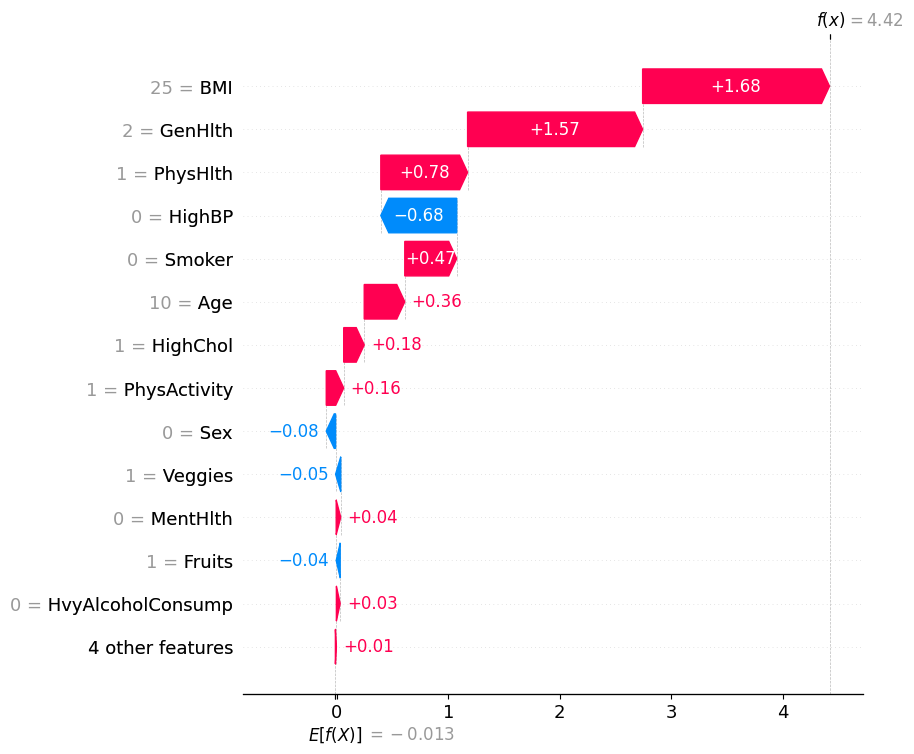

In [25]:
# Inserte código para generar gráficos de aporte local aquí
idx=1
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

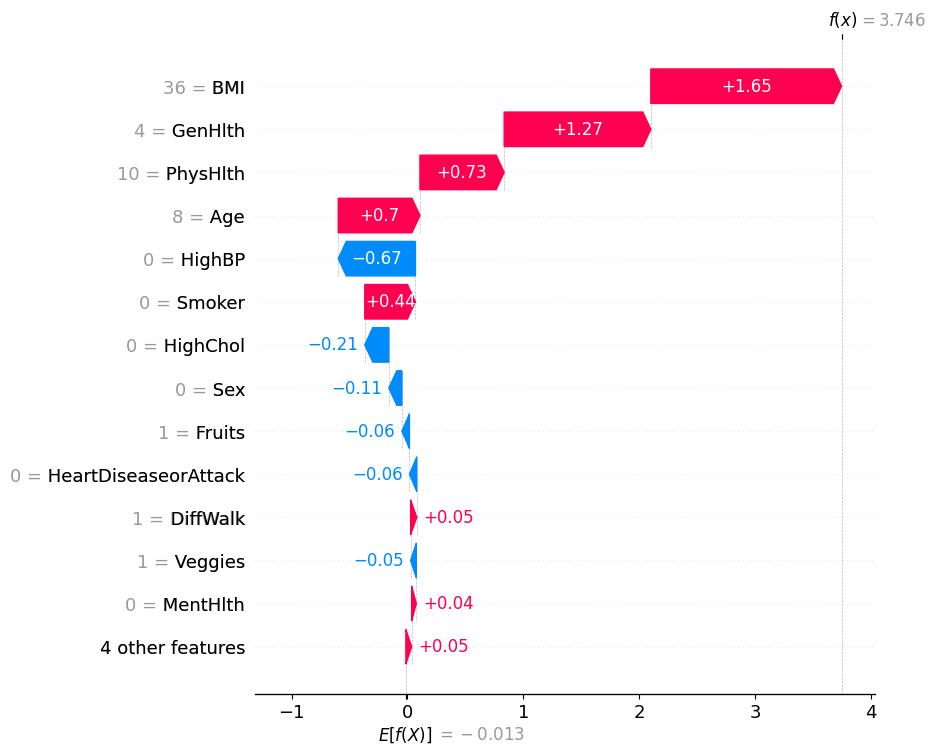

In [26]:
idx=9
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

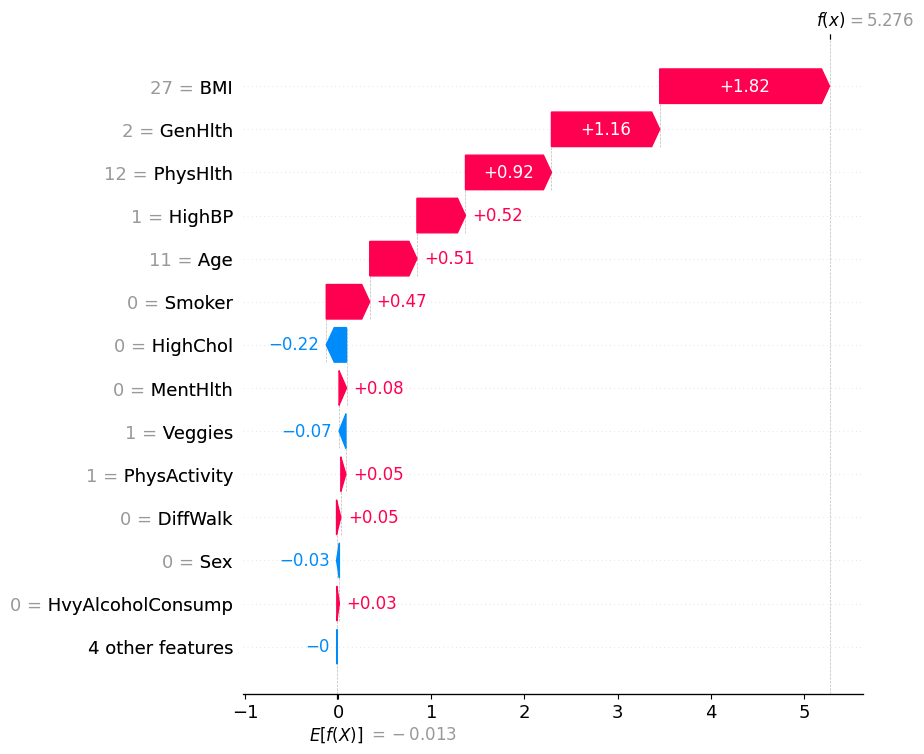

In [27]:
idx=150
shap.plots.waterfall(shap_values[idx,:], 
                     max_display=14)

#### Respuestas:

Se observa a partir de los graficos que las tres primeras features('BMI', 'GenHlth', 'PhysHlth'), se mantienen en el mismo orden y con magnitudes similares, lo cual indica que estas features son las que más afectan de manera positiva a la predicción. 

Para las demás features, se tiene que casi todas tienen valores muy cercanos a cero, lo cual indica que no tienen un gran impacto en la predicción.

Por último, para generalizar estas conclusiones es necesario analizar el comportamiento sobre todo el dataset. 

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

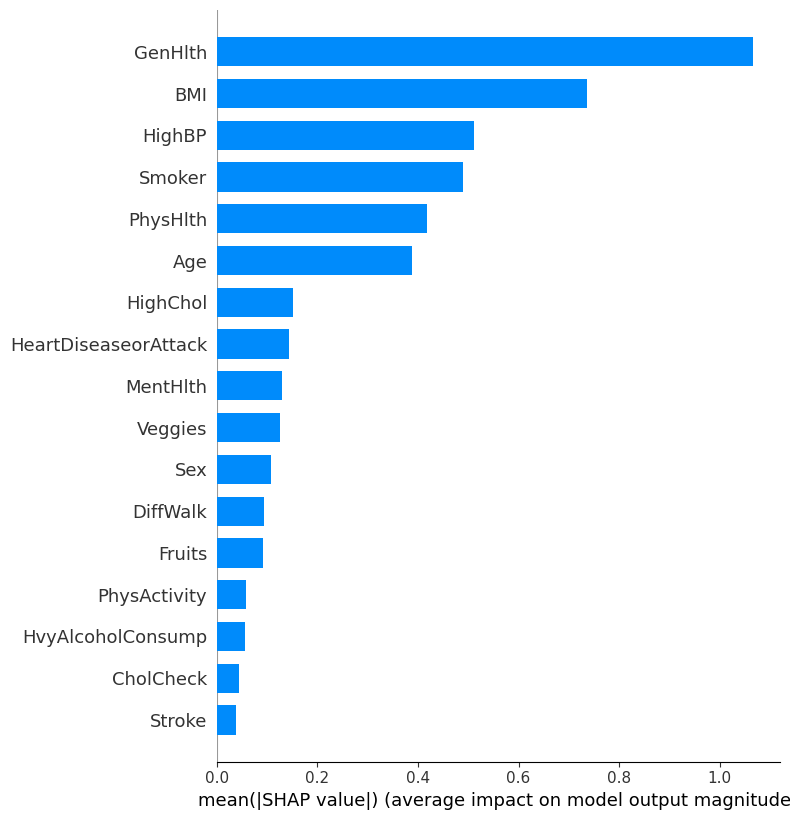

In [28]:
# Inserte código para generar gráficos de aporte global aquí
shap.summary_plot(shap_values, X_train, plot_type="bar")

Las primeras tres features se mantienen pero en otro orden, esto refleja la importancia de realizar estos análisis de manera global. 

Además, se observa que otras variables como la 'Age' también se hace presente con un impacto positivo, lo cual no se observó para las instancias revisadas.  

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

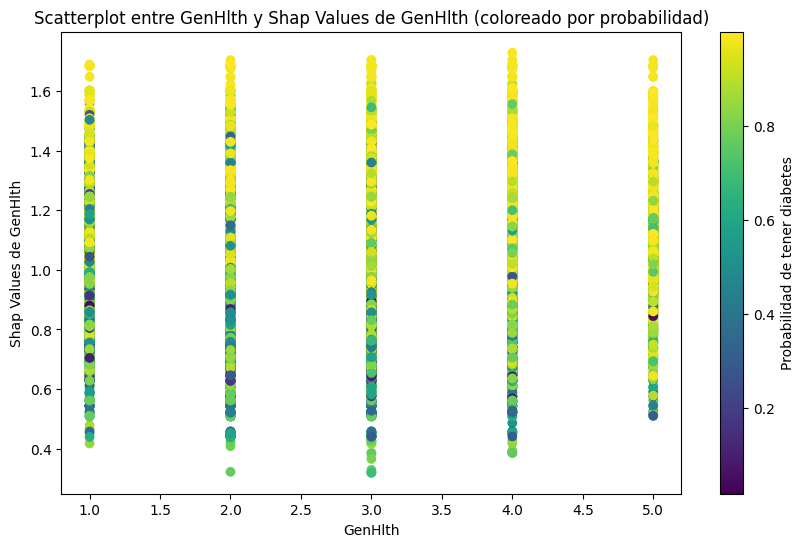

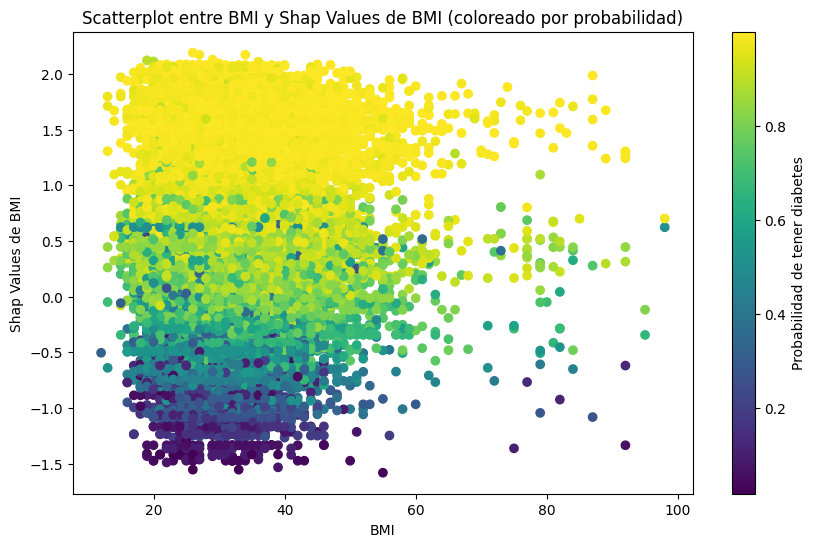

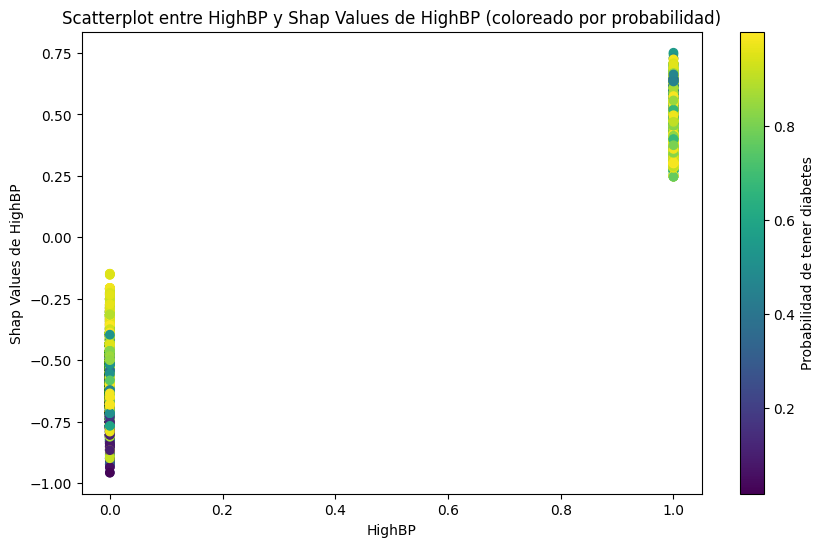

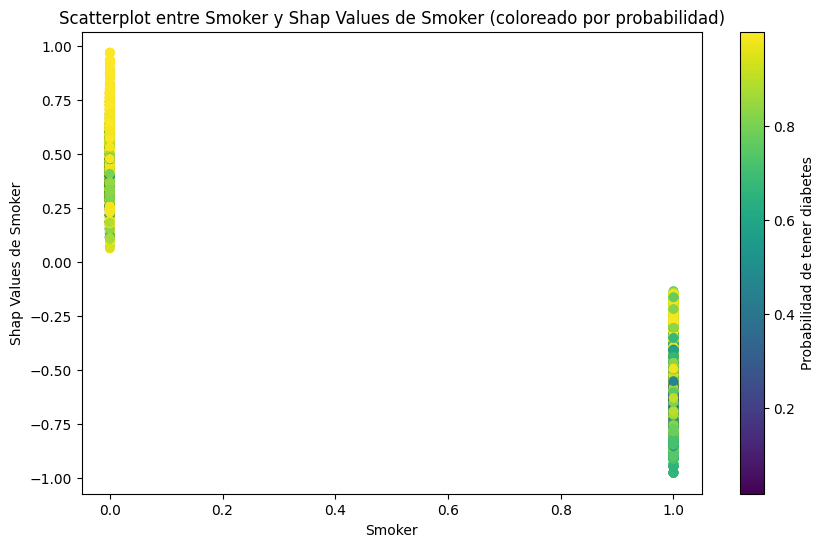

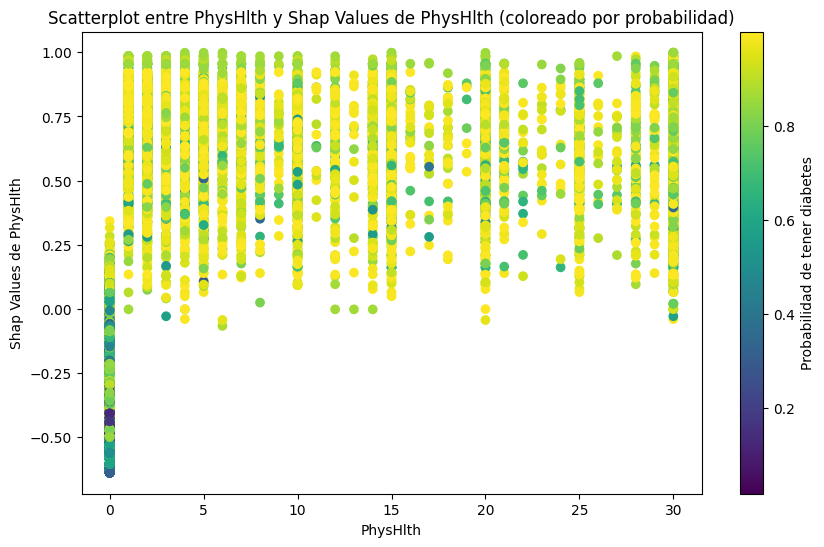

In [54]:
# Inserte código para generar gráficos de feature vs shap value aquí
shap_values_df = pd.DataFrame(shap_values.values, columns=X_train.columns)

# Obtener las características con mayor impacto global
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)
feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]
top_features = feature_importance_names[:5].tolist()

# Obtener las probabilidades de tener diabetes
predictions_proba = pipeline_xgb['classifier'].predict_proba(X_train)[:, 1]

# Generar gráficos de características vs. Shap values para las 5 características principales
for feature in top_features:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train[feature], shap_values_df[feature], c=predictions_proba, cmap='viridis')
    plt.title(f'Scatterplot entre {feature} y Shap Values de {feature} (coloreado por probabilidad)')
    plt.xlabel(f'{feature}')
    plt.ylabel(f'Shap Values de {feature}')
    plt.colorbar(label='Probabilidad de tener diabetes')
    plt.show()


A partir de los 5 gráficos se puede notar que en todos los gráficos, los valores shap se centran en regiones especificas de acuerdo a las clases.

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

In [ ]:
features = []
for name in feature_importance_names[:5]:
    features.append(name)
features

['GenHlth', 'BMI', 'HighBP', 'Smoker', 'PhysHlth']

Los siguientes códigos están comentados por guardar el orden, surge un warning al ejecutarlos y el output ensucia el notebook

In [ ]:
""" # Inserte código para generar gráficos PDP aquí
X1000 = shap.utils.sample(X_train, 1000)

sample_ind = 20

shap.partial_dependence_plot(
    'GenHlth', pipeline_xgb['classifier'].predict, X1000, model_expected_value=True,
    feature_expected_value=True, ice=True,
    shap_values=shap_values[sample_ind:sample_ind+1,:]) """

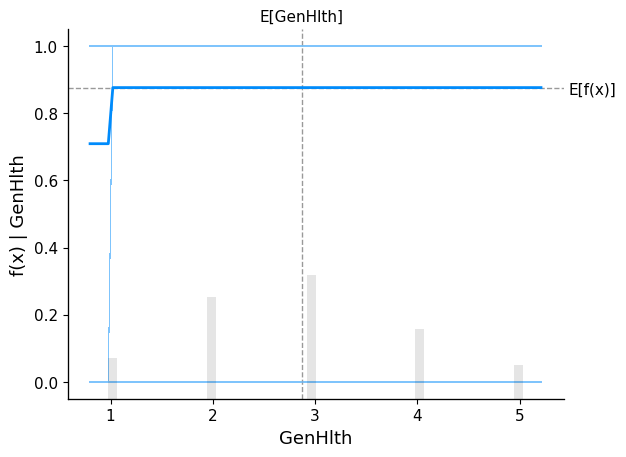

In [ ]:
""" # Inserte código para generar gráficos PDP aquí
X1000 = shap.utils.sample(X_train, 1000)

sample_ind = 20

shap.partial_dependence_plot(
    'BMI', pipeline_xgb['classifier'].predict, X1000, model_expected_value=True,
    feature_expected_value=True, ice=True,
    shap_values=shap_values[sample_ind:sample_ind+1,:]) """

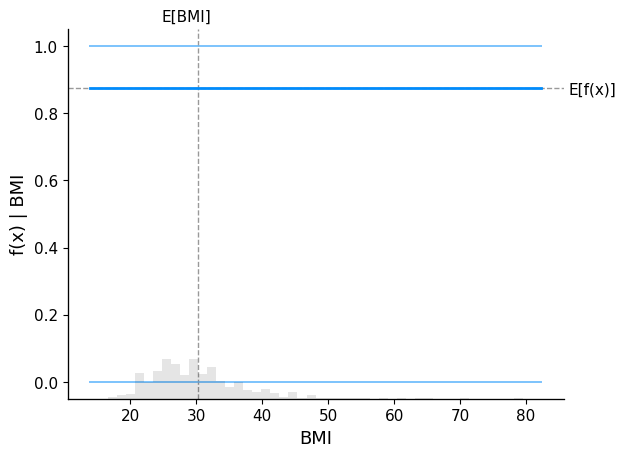

En el caso del gráfico BMI, observamos que la esperanza es 

In [ ]:
""" # Inserte código para generar gráficos PDP aquí
X1000 = shap.utils.sample(X_train, 1000)

sample_ind = 20

shap.partial_dependence_plot(
    'HighBP', pipeline_xgb['classifier'].predict, X1000, model_expected_value=True,
    feature_expected_value=True, ice=True,
    shap_values=shap_values[sample_ind:sample_ind+1,:]) """

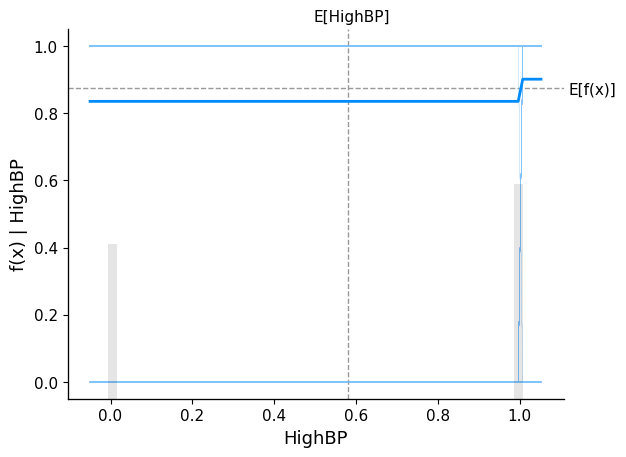

In [ ]:
""" # Inserte código para generar gráficos PDP aquí
X1000 = shap.utils.sample(X_train, 1000)

sample_ind = 20

shap.partial_dependence_plot(
    'Smoker', pipeline_xgb['classifier'].predict, X1000, model_expected_value=True,
    feature_expected_value=True, ice=True,
    shap_values=shap_values[sample_ind:sample_ind+1,:]) """

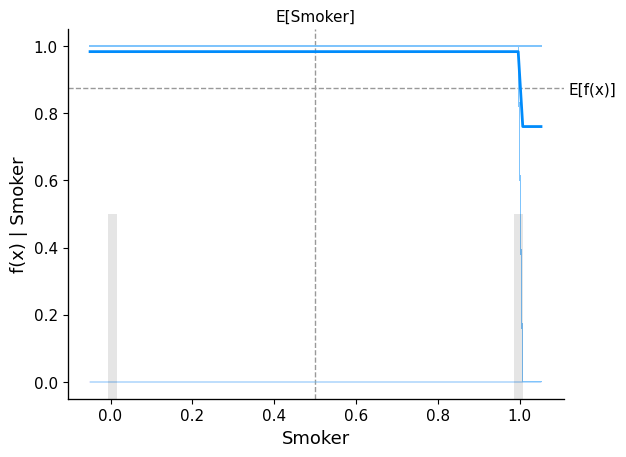

In [ ]:
""" # Inserte código para generar gráficos PDP aquí
X1000 = shap.utils.sample(X_train, 1000)

sample_ind = 20

shap.partial_dependence_plot(
    'PhysHlth', pipeline_xgb['classifier'].predict, X1000, model_expected_value=True,
    feature_expected_value=True, ice=True,
    shap_values=shap_values[sample_ind:sample_ind+1,:]) """

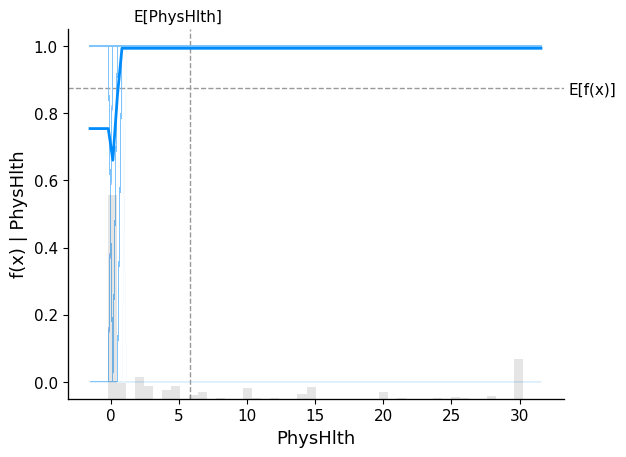

En general podemos identificar que en los gráficos las predicciones son similares en valores. Para los posibles valores que toman la mayoría de variables vemos que el valor de f(X) es practicamente constante, lo que indicaría una relación lineal entre la variable y la salida del modelo. Sin embargo esto podría no ser cierto ya que podrían existir relaciones más complejas en el modelo. 

En general vemos que para estas variables el modelo logra clasificar de buena, la gráfica es continua y constante en casi todos los posibles valores. Sin embargo es importante mencionar que esta observación, no es extrapolable al resto de datos del conjunto. Puede ocurrir que para determinado subconjunto se presente una relación específica entre la feature y la predicción. 



## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [ ]:
#!pip install alibi

^C


  Using cached alibi-0.9.4-py3-none-any.whl (524 kB)
  Using cached spacy-3.7.2-cp311-cp311-win_amd64.whl (12.1 MB)
  Using cached blis-0.7.11-cp311-cp311-win_amd64.whl (6.6 MB)
  Using cached scikit_image-0.21.0-cp311-cp311-win_amd64.whl (22.8 MB)
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached dill-0.3.7-py3-none-any.whl (115 kB)
  Using cached transformers-4.35.2-py3-none-any.whl (7.9 MB)
  Using cached charset_normalizer-3.3.2-cp311-cp311-win_amd64.whl (99 kB)
  Using cached idna-3.4-py3-none-any.whl (61 kB)
  Using cached certifi-2023.11.17-py3-none-any.whl (162 kB)
  Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
  Using cached lazy_loader-0.3-py3-none-any.whl (9.1 kB)
  Using cached murmurhash-1.0.10-cp311-cp311-win_amd64.whl (25 kB)
  Using cached preshed-3.0.9-cp311-cp311-win_amd64.whl (122 kB)
  Using cached thinc-8.2.1-cp311-cp311-win_amd64.whl (1.5 MB)
  Using cached srsly-2.4.8-cp311-cp311-win_amd64.whl (479 kB)
  Using cached catalogue-2.0.10


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from alibi.explainers.anchors.anchor_tabular import AnchorTabular

In [ ]:
# Inserte su código para generar sistema de reglas aquí
predict_fn = lambda x: pipeline_xgb['classifier'].predict(x)
explainer = AnchorTabular(predict_fn, X_train.columns, seed=1)
explainer.fit(X_train.to_numpy())

class_names = ['No Diabetes', 'Diabetes']

idx = 1000
# explicar predicción idx 1000
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.9)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])


Prediction:  Diabetes


In [ ]:
# Inserte su código para generar sistema de reglas aquí
predict_fn = lambda x: pipeline_xgb['classifier'].predict(x)
explainer = AnchorTabular(predict_fn, X_train.columns, seed=1)
explainer.fit(X_train.to_numpy())

class_names = ['No Diabetes', 'Diabetes']

idx = 1000
# explicar predicción idx 1000
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.9)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)
print('\n')


idx = 3001
# explicar predicción idx 3001
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.9)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)
print('\n')

idx = 5751
# explicar predicción idx 5751
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.9)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  Diabetes
Anchor: Fruits > 0.00
Precision: 0.95
Coverage: 0.61


Prediction:  No Diabetes
Anchor: Smoker > 0.00 AND PhysHlth <= 0.00 AND MentHlth > 0.00 AND Age <= 7.00
Precision: 0.96
Coverage: 0.02


Prediction:  No Diabetes
Anchor: Smoker > 0.00 AND PhysHlth <= 0.00 AND Fruits <= 0.00 AND HighChol > 0.00 AND HighBP <= 0.00
Precision: 0.93
Coverage: 0.01


# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> Fundamente su Respuesta aquí

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>